<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-the-data-and-split-into-training-and-test-datasets.-We-will-be-using-the-training-part-to-further-split-into-training-and-validation-part.-Once-we-find-a-good-model-we-will-test-it's-performance-on-unseen-data-(test-dataset)" data-toc-modified-id="Read-the-data-and-split-into-training-and-test-datasets.-We-will-be-using-the-training-part-to-further-split-into-training-and-validation-part.-Once-we-find-a-good-model-we-will-test-it's-performance-on-unseen-data-(test-dataset)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><strong>Read the data and split into training and test datasets. We will be using the training part to further split into training and validation part. Once we find a good model we will test it's performance on unseen data (test dataset)</strong></a></span></li><li><span><a href="#Compare-CountVectorizer-and-TfidfVectorizer-by-passing-the-document-term-matrix-from-the-two-vectorizers-through-MultinomialNB()" data-toc-modified-id="Compare-CountVectorizer-and-TfidfVectorizer-by-passing-the-document-term-matrix-from-the-two-vectorizers-through-MultinomialNB()-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Compare CountVectorizer and TfidfVectorizer by passing the document-term-matrix from the two vectorizers through MultinomialNB()</strong></a></span><ul class="toc-item"><li><span><a href="#Create-a-switcher-function-to-call-for-different-estimators-to-test" data-toc-modified-id="Create-a-switcher-function-to-call-for-different-estimators-to-test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create a switcher function to call for different estimators to test</a></span></li><li><span><a href="#Create-a-pipeline-to-grid-search-hyperparameters-for-CountVectorizer-and-TF-IDF-vectorizer" data-toc-modified-id="Create-a-pipeline-to-grid-search-hyperparameters-for-CountVectorizer-and-TF-IDF-vectorizer-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Create a pipeline to grid search hyperparameters for CountVectorizer and TF-IDF vectorizer</a></span></li><li><span><a href="#Findings" data-toc-modified-id="Findings-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Findings</a></span></li></ul></li><li><span><a href="#Using-vectorizer-selected-above,-create-pipeline,-and-perform-grid-search-to-find-best-estimator-and-best-parameters." data-toc-modified-id="Using-vectorizer-selected-above,-create-pipeline,-and-perform-grid-search-to-find-best-estimator-and-best-parameters.-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>Using vectorizer selected above, create pipeline, and perform grid search to find best estimator and best parameters.</strong></a></span><ul class="toc-item"><li><span><a href="#Gridsearch-Logistic-Regression-Classifier" data-toc-modified-id="Gridsearch-Logistic-Regression-Classifier-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gridsearch Logistic Regression Classifier</a></span></li><li><span><a href="#Gridsearch-Multinomial-Naive-Bayes-Classifier" data-toc-modified-id="Gridsearch-Multinomial-Naive-Bayes-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Gridsearch Multinomial Naive Bayes Classifier</a></span></li><li><span><a href="#Gridsearch-Random-Forest-Classifier" data-toc-modified-id="Gridsearch-Random-Forest-Classifier-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gridsearch Random Forest Classifier</a></span></li><li><span><a href="#Gridsearch-XGBoost-Classifier" data-toc-modified-id="Gridsearch-XGBoost-Classifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Gridsearch XGBoost Classifier</a></span></li><li><span><a href="#Display-summary-of-grid-search-for-all-the-models" data-toc-modified-id="Display-summary-of-grid-search-for-all-the-models-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Display summary of grid search for all the models</a></span></li><li><span><a href="#Plot-ROC-curve-logistic-regression-classifier" data-toc-modified-id="Plot-ROC-curve-logistic-regression-classifier-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Plot ROC curve logistic regression classifier</a></span></li><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Confusion Matrix</a></span></li></ul></li><li><span><a href="#Adjust-Threshold-as-per-business-usecase" data-toc-modified-id="Adjust-Threshold-as-per-business-usecase-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><strong>Adjust Threshold as per business usecase</strong></a></span></li><li><span><a href="#Top-misclassified-comments" data-toc-modified-id="Top-misclassified-comments-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Top misclassified comments</a></span><ul class="toc-item"><li><span><a href="#False-negatives-(miscalssified-as-Ham)" data-toc-modified-id="False-negatives-(miscalssified-as-Ham)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>False-negatives (miscalssified as Ham)</a></span></li><li><span><a href="#False-positives-(miscalssified-as-Spam)" data-toc-modified-id="False-positives-(miscalssified-as-Spam)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>False-positives (miscalssified as Spam)</a></span></li></ul></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save the model</a></span></li><li><span><a href="#Read-comments-from-youtube-to-test-model-performance" data-toc-modified-id="Read-comments-from-youtube-to-test-model-performance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Read comments from youtube to test model performance</a></span></li></ul></div>

In [126]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=(15,5)
pd.set_option('display.max_columns', 100)

import nltk
from scipy import stats
import re
from  scipy.stats import ttest_ind
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,roc_curve,fbeta_score,make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from cf_matrix import make_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator,TransformerMixin

import Helper 
import importlib
importlib.reload(Helper);
from sklearn.externals import joblib

### **Read the data and split into training and test datasets. We will be using the training part to further split into training and validation part. Once we find a good model we will test it's performance on unseen data (test dataset)**

In [127]:
data=pd.read_csv('Data/cleanedData.csv')
data.dropna(subset=['CleanWordList'],inplace=True)

# Meta features
cols=['COMMENT_ID','%OfUpperCaseLetters', 'NoOfURL', 'AvgLengthOfEachWord',
       '%OfNoOfStopWords', 'NoOfWords', '%OfNoOfUniqueWords',
       'AvgSentenceLength', 'TextStandard', 'CleanWordList']

X=data.loc[:,cols]
y=data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,stratify=y,random_state=147)

In [128]:
print('X_train, X_test, y_train, y_test: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train, X_test, y_train, y_test:  (1423, 10) (475, 10) (1423,) (475,)


### **Compare CountVectorizer and TfidfVectorizer by passing the document-term-matrix from the two vectorizers through MultinomialNB()**

#### Create a switcher function to call for different estimators to test

Reference: https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers

In [129]:
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator=LogisticRegression(),):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        Default estimator: LogisticRegression()
        """ 
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

In [130]:
class Transfomer(BaseEstimator, TransformerMixin):
    
    def __init__(self,vectorizer=CountVectorizer()):
        self.vectorizer=vectorizer
        self.X=X

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self.vectorizer.fit(X)

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return self.vectorizer.transform(X).toarray()

#### Create a pipeline to grid search hyperparameters for CountVectorizer and TF-IDF vectorizer

In [131]:
pipe_CompareVectorizer= Pipeline([('vectorizer',Transfomer()),
                                  ('clf', ClfSwitcher())
                                ])
paramGrid_CompareVectorizer=[ {
                            'vectorizer__vectorizer':[TfidfVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[LogisticRegression()]
                              },
                              {
                            'vectorizer__vectorizer':[CountVectorizer()],
                            'vectorizer__vectorizer__min_df':[0.1,0.01,0.001,0.0001],
                            'vectorizer__vectorizer__ngram_range':[(1,2),(1,3)],
                            'clf__estimator':[LogisticRegression()]
                              }
                            ]

cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Gridsearch with count vectorizer and TFIDF
gs_CompareVectorizer = GridSearchCV(pipe_CompareVectorizer, param_grid=paramGrid_CompareVectorizer,n_jobs=-1,
                                    cv=cv, verbose=0,return_train_score=True,scoring='roc_auc')

gs_CompareVectorizer.fit(X_train['CleanWordList'],y_train);

gs_CompareVectorizer.best_params_['vectorizer__vectorizer']

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=0.001,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

It is interesting to find that CountVectorizer outperformed TF-IDF. The selected value for min_df is 0.0001, i.e 0.01%, and ngram_range=(1,2).

#### Findings

In [132]:
# List of all the combinations tried in grid search in descinding order of ROC_AUC_Score.

compareVectorizer=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'],
                  gs_CompareVectorizer.cv_results_['mean_train_score']).reset_index()
compareVectorizer['clf__estimator']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['clf__estimator'].apply(lambda x: str(x).split('(')[0])
compareVectorizer['vectorizer__vectorizer']=pd.DataFrame(gs_CompareVectorizer.cv_results_['params'])['vectorizer__vectorizer'].apply(lambda x: str(x).split('(')[0])

compareVectorizer.rename(columns={'index':'ROC_AUC_SCORE',
                    'clf__estimator':'Estimator',
                    'vectorizer__vectorizer':'Vectorizer',
                    'vectorizer__vectorizer__min_df':'min_df',
                    'vectorizer__vectorizer__ngram_range':'ngram_range'},inplace=True)
compareVectorizer.sort_values(by=['ROC_AUC_SCORE'],ascending=False,inplace=True)
compareVectorizer.reset_index(inplace=True,drop=True)
compareVectorizer.head()

,ROC_AUC_SCORE,Estimator,Vectorizer,min_df,ngram_range
0,0.999496,LogisticRegression,CountVectorizer,0.0001,"(1, 3)"
1,0.999405,LogisticRegression,CountVectorizer,0.0001,"(1, 2)"
2,0.997638,LogisticRegression,TfidfVectorizer,0.0001,"(1, 3)"
3,0.997583,LogisticRegression,CountVectorizer,0.0010,"(1, 3)"
4,0.997489,LogisticRegression,CountVectorizer,0.0010,"(1, 2)"


Here CountVectorizer with min_df=0.0001 and ngram_range=(1,3) has performed the best. CountVectorizer with same min_df and ngram_range=(1,2) is second on the list by a very small margin. 

Best score is different than the top score from above table????


In [133]:
gs_CompareVectorizer.best_score_

0.9702148681112805

In [134]:
bestVectorizer=gs_CompareVectorizer.best_estimator_['vectorizer']
bestVectorizer

Transfomer(vectorizer=CountVectorizer(analyzer='word', binary=False,
                                      decode_error='strict',
                                      dtype=<class 'numpy.int64'>,
                                      encoding='utf-8', input='content',
                                      lowercase=True, max_df=1.0,
                                      max_features=None, min_df=0.001,
                                      ngram_range=(1, 2), preprocessor=None,
                                      stop_words=None, strip_accents=None,
                                      token_pattern='(?u)\\b\\w\\w+\\b',
                                      tokenizer=None, vocabulary=None))

###  **Using vectorizer selected above, create pipeline, and perform grid search to find best estimator and best parameters.**

#### Gridsearch Logistic Regression Classifier

In [135]:
classifier=LogisticRegression()
param_grid={'clf__C':(0.1,0.5,1,1.5,2,20,50,100,500)}

gs=Helper.gridSearch()
lr_gridSearch=gs.gridSearchEstimator(X_train, y_train,n_splits=2,vectorizer=bestVectorizer,
                                     clf=classifier, param_grid=param_grid);

 Best param:  {'clf__C': 1} 
 Best Score:  0.9619657930180845


 #### Gridsearch Multinomial Naive Bayes Classifier

In [136]:
classifier=MultinomialNB()
param_grid={'clf__alpha':(0,0.1,0.5,1,2,20,100),
            'clf__fit_prior':(True,False)}


mn_gridSearch=gs.gridSearchEstimator(X_train, y_train,n_splits=5, vectorizer=bestVectorizer, 
              clf=classifier, param_grid=param_grid);

 Best param:  {'clf__fit_prior': False, 'clf__alpha': 0.1} 
 Best Score:  0.954285152866747


#### Gridsearch Random Forest Classifier

In [137]:
classifier=RandomForestClassifier()
param_grid={'clf__n_estimators':(10,50,100,500,1000,1500,2000),
            'clf__max_depth':(2,5,10,50,100)}


rf_gridSearch=gs.gridSearchEstimator(X_train, y_train,n_splits=5, vectorizer=bestVectorizer, 
              clf=classifier, param_grid=param_grid);

 Best param:  {'clf__n_estimators': 1500, 'clf__max_depth': 50} 
 Best Score:  0.9737691967080089


#### Gridsearch XGBoost Classifier

In [138]:
classifier=XGBClassifier()
# param_grid={'clf__n_estimators':(10,50,100,500,1000),
#             'clf__max_depth':(2,5,10,50,100,500,1000)}

param_grid={'clf__n_estimators':(10,20),
            'clf__max_depth':(2,5)}

xgb_gridSearch=gs.gridSearchEstimator(X_train, y_train,n_splits=2, vectorizer=bestVectorizer,
              clf=classifier, param_grid=param_grid);

 Best param:  {'clf__n_estimators': 10, 'clf__max_depth': 2} 
 Best Score:  0.4992458092808831


#### Display summary of grid search for all the models

In [139]:
compareEstimator_df=pd.DataFrame(data={'Logistic Regression':[lr_gridSearch[0],lr_gridSearch[1]],
 'Multinomial Naive Bayes':[mn_gridSearch[0],mn_gridSearch[1]],
 'Random Forest':[rf_gridSearch[0],rf_gridSearch[1]],
 'XGBoost':[xgb_gridSearch[0],xgb_gridSearch[1]]},index=['Best Params','Best ROC_AUC Score']).transpose()

compareEstimator_df.sort_values(by='Best ROC_AUC Score',ascending=False,inplace=True)

compareEstimator_df.style.highlight_max(axis=0,subset=['Best ROC_AUC Score'])

,Best Params,Best ROC_AUC Score
Random Forest,"{'clf__n_estimators': 1500, 'clf__max_depth': 50}",0.973769
Logistic Regression,{'clf__C': 1},0.961966
Multinomial Naive Bayes,"{'clf__fit_prior': False, 'clf__alpha': 0.1}",0.954285
XGBoost,"{'clf__n_estimators': 10, 'clf__max_depth': 2}",0.499246


Logistic regression has the highest ROC_AUC score with C=2.

#### Plot ROC curve logistic regression classifier

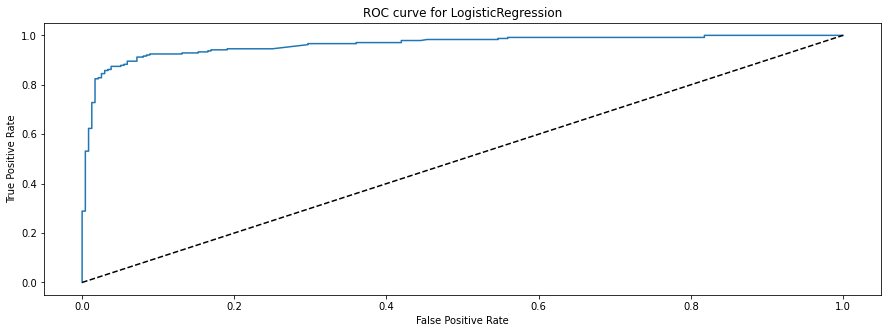

In [140]:
Helper.plot_Roc_Curve(lr_gridSearch[2],X_test,y_test);

#### Confusion Matrix

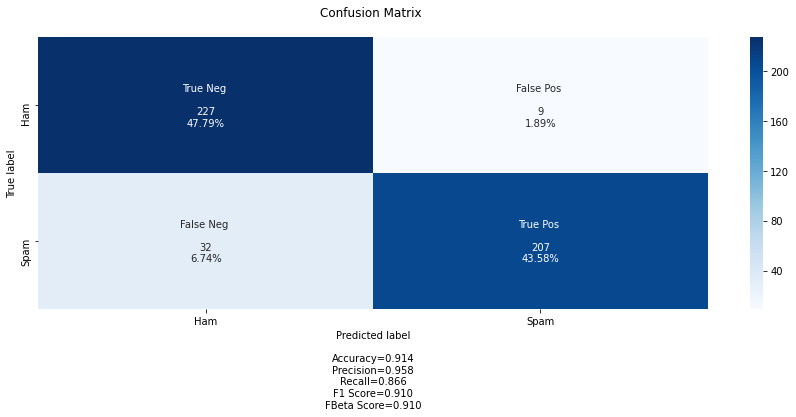

In [141]:
import cf_matrix
# Reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

labels = ['True Neg \n','False Pos \n','False Neg \n','True Pos \n']

cm=confusion_matrix(y_test,lr_gridSearch[2].predict(X_test['CleanWordList']))

cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

### **Adjust Threshold as per business usecase**

The default threshold for the model is 0.5, i.e any document having predict_proba <0.5 is classified as Ham and Spam otherwise.  Using 0.5 as threshold, the current model has 1.68% False Positive,i.e. 1.68% of total comments were misclassified as Spam when actually they were non-spam comments. Whereas, 5.45% of total comments are classified as Ham when they were actually spam. 


The level of tolerance of False-Positives and False-Negative varies from case to case. 
There are 3 important metrics which are calculated from values of true-pos, false-pos,true-neg and false-neg. 

- Precision: Out of all the comments flagged as Spam, what fraction are actually spam.
- Recall: Out of all the spam comments, what fraction got flagged as spam. 
- F1 Score: It combines the first two metrics using harmonic mean. It gives equal weightage to precision and recall.


Precision is a good measure to determine when the costs of False Positives are high. For instance, email spam detection. In email spam detection, a false positive means that an email that is non-spam (actual negative) has been identified as spam (predicted spam). The email user might lose important emails if the precision is not high for the spam detection model. On the other hand, in case of cancerous cell detection problems the opposite is true. The goal in this case will be to have the lowest possible False-Negatives (Cancerous cell mis-classified as non-cancerous). An increase in False-Positive will be acceptable in this case if it helps reduce no. of False-Negatives.


F1 Score is a better measure to use if we are seeking a balance between precision and recall and there is an imbalanced class distribution. For this project, I am more inclined to achieve better precision than recall. I used the FBeta score as it allows to adjust the value of beta to give more weight to precision or recall. Beta < 1 gives more weight to precision, while beta > 1 favors recall.


I searched for the optimal value of beta for a number of thresholds.


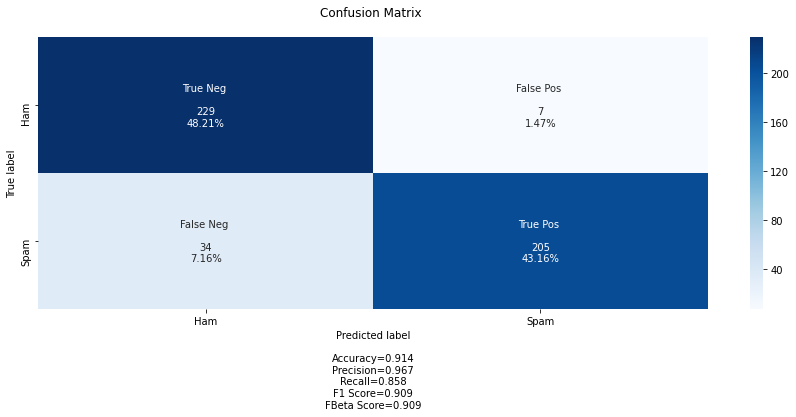

In [142]:
predict_proba=lr_gridSearch[2].predict_proba(X_test['CleanWordList'])[:,1]
helper=Helper.analysisHelper()
cm=confusion_matrix(y_test,helper.predictNewThreshold(predict_proba=predict_proba,threshold=0.6))

cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

In [143]:
ah=Helper.analysisHelper()

betaValues=[0.4,0.5,0.6,0.7,0.8,0.9,0.99]
beta=[]
threshold=[]
FbetaScore=[]
for betaValue in betaValues:
    a,b,c= ah.plotThresholdvsMetric_adjustedBeta(gs=lr_gridSearch[2],X_test=X_test,y_test=y_test,
                                      beta=betaValue,isChart=False)
    beta.append(a)
    threshold.append(b)
    FbetaScore.append(c)
    

In [144]:
pd.DataFrame(data={'Beta':beta,'Threshold':threshold,'Fbeta Score':FbetaScore}).\
             style.highlight_max(subset=['Fbeta Score'])
   

,Beta,Threshold,Fbeta Score
0,0.4,0.75,0.960594
1,0.5,0.75,0.95082
2,0.6,0.65,0.941828
3,0.7,0.58,0.935155
4,0.8,0.58,0.928868
5,0.9,0.49,0.923345
6,0.99,0.38,0.919465


(0.4, 0.75, 0.9605939463163907)

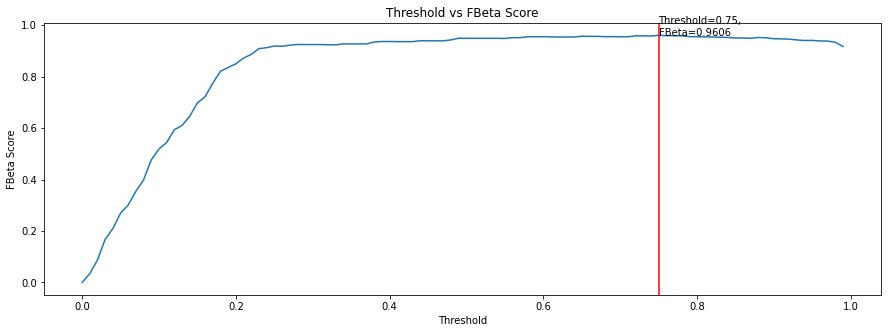

In [145]:
ah.plotThresholdvsMetric_adjustedBeta(gs=lr_gridSearch[2],X_test=X_test,y_test=y_test,
                                      beta=0.4,isChart=True)

**Check confusion matrix with threshold=0.6**

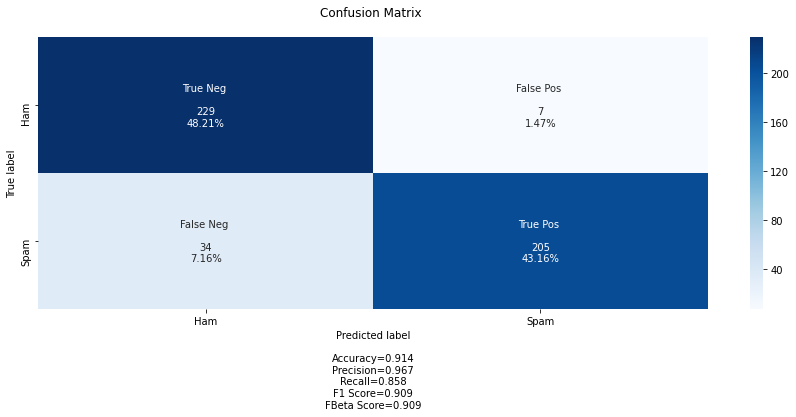

In [146]:
cm=confusion_matrix(y_test,ah.predictNewThreshold(predict_proba,0.6))
cf_matrix.make_confusion_matrix(cm,figsize=(15,5),categories=['Ham','Spam'],
                                title='Confusion Matrix \n',group_names=labels)

In [147]:
predict_proba=lr_gridSearch[2].predict_proba(X_test['CleanWordList'])[:,1]
print(classification_report(y_test,ah.predictNewThreshold(predict_proba,0.6)))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       236
           1       0.97      0.86      0.91       239

    accuracy                           0.91       475
   macro avg       0.92      0.91      0.91       475
weighted avg       0.92      0.91      0.91       475



###  Top misclassified comments

In [148]:
predict_proba=lr_gridSearch[2].predict_proba(X_test['CleanWordList'])[:,1]
helper=Helper.analysisHelper()
cm=confusion_matrix(y_test,helper.predictNewThreshold(predict_proba=predict_proba,threshold=0.6))

prediction_df=pd.DataFrame(data={'X_test':X_test['CleanWordList'],
                  'y_test':y_test,
                  'predict_proba':predict_proba,
                  'Prediction':helper.predictNewThreshold(predict_proba=predict_proba,threshold=0.6)})

merged=pd.merge(prediction_df,data,how='left',left_on='X_test',right_on='CleanWordList',)

cols=['X_test','CONTENT','y_test', 'predict_proba', 'Prediction']
merged=merged[cols]
merged.drop_duplicates(inplace=True)

In [150]:
filtHam=(merged['Prediction']==1) & (merged['y_test']==0) 
misclassifiedHam=merged[filtHam].sort_values(by='predict_proba',ascending=False)

filtSpam=(merged['Prediction']==0) & (merged['y_test']==1) 
misclassifiedSpam=merged[filtSpam].sort_values(by='predict_proba',ascending=False)

pd.set_option('display.max_colwidth', -1)

#### False-negatives (miscalssified as Ham)

In [172]:
misclassifiedHam.loc[:,['CONTENT','predict_proba']].reset_index(drop=True).head()

,CONTENT,predict_proba
0,"My honest opinion. It's a very mediocre song. Nothing unique or special about her music, lyrics or voice. Nothing memorable like Billie Jean or Beat It. Before her millions of fans reply with hate comments, i know this is a democracy and people are free to see what they want. But then don't I have the right to express my opinion? Please don't reply with dumb comments lie ""if you don't like it don't watch it"". I just came here to see what's the buzz about(661 million views??) and didn't like what i saw. OK?﻿",0.997661
1,thumbs up if u checked this video to see hw views it got﻿,0.982619
2,i check back often to help reach 2x10^9 views and I avoid watching Baby﻿,0.947128
3,Lemme Top Comments Please!!﻿,0.872129
4,This comment will randomly get lot's of likes and replies for no reason. I also like Jello. Strawberry jello.﻿,0.744380


#### False-positives (miscalssified as Spam)

In [179]:
misclassifiedSpam.loc[:,['CONTENT','predict_proba']].reset_index(drop=True).\
drop_duplicates(subset=['CONTENT']).head()

,CONTENT,predict_proba
0,i love this so much. AND also I Generate Free Leads on Auto Pilot &amp; You Can Too! http://www.MyLeaderGate.com/moretraffic﻿,0.554955
1,"Haha , Miley Cyrus has done it once again Today someone leeched a porno video with her on a celeb site I believe the website link is : miley-celeb-news.co.uk in case you want to view it....",0.547022
2,"It's so hard, sad :( iThat little child Actor HWANG MINOO dancing very active child is suffering from brain tumor, only 6 month left for him .Hard to believe .. Keep praying everyone for our future superstar. #StrongLittlePsY #Fighting SHARE EVERYONE PRAYING FOR HIM http://ygunited.com/2014/11/08/little-psy-from-the-has-brain-tumor-6-months-left-to-live/ ﻿",0.492424
3,-----&gt;&gt;&gt;&gt; https://www.facebook.com/video.php?v=10200253113705769&amp;set=vb.201470069872822&amp;type=3&amp;permPage=1 &lt;--------﻿,0.489175
4,http://www.twitch.tv/jaroadc come follow and watch my stream!﻿,0.445956


### Save the model

In [156]:
joblib.dump(lr_gridSearch, 'youtubeCommentClassifier_pipeline.joblib')

['youtubeCommentClassifier_pipeline.joblib']

In [157]:
clf=joblib.load('youtubeCommentClassifier_pipeline.joblib')

### Read comments from youtube to test model performance

In [158]:
import importlib
import YoutubeAPICommentExtractor
importlib.reload(YoutubeAPICommentExtractor);
import YoutubeAPICommentExtractor as api

In [159]:
api.ReadYoutubeComments.read_required_no_of_comments(url='https://www.youtube.com/watch?v=54nu59EZwF8',requiredNoOfComments=500)

AttributeError: module 'YoutubeAPICommentExtractor' has no attribute 'ReadYoutubeComments'

In [ ]:
api.read_required_no_of_comments(url='https://www.youtube.com/watch?v=54nu59EZwF8',requiredNoOfComments=500)

In [ ]:
api.read_required_no_of_comments(url='https://www.youtube.com/watch?v=54nu59EZwF8',requiredNoOfComments=500)